<a href="https://colab.research.google.com/github/h-j-hyun/NCoin-DP/blob/main/CIR_A_n%3D2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
n = 2000

# Initial points
y0 = 0.1
delta = 1/12

# time inteval
obtime = np.arange(0,n+1)/n * n * delta

In [ ]:
def CIR_sample(del_CIR, m_CIR, y0_CIR, a_CIR, b_CIR, sigma_CIR):
    """
    This function generates a one sample path between an interval for CIR process
    y0_CIR: initial value
    m : num of slice of each interval
    t_CIR: time array including initial point
    a, b, sigma are parameters of CIR process dX_t = a (b - X_t)dt + \sigma sqrt{X_t} dBt
    """
    L_tmp = a_CIR.size()[0]
    del_tmp = del_CIR / m_CIR
    z0 = y0_CIR
    for j in range(m_CIR):
        ran_num = torch.normal(0 * torch.ones(L_tmp),1 * torch.ones(L_tmp))
        z0 = z0 + a_CIR*(b_CIR-z0)*del_tmp + sigma_CIR * torch.sqrt(z0)*((del_tmp)**(1/2))*ran_num + (torch.pow(sigma_CIR,2) )/2 *(del_tmp*(torch.pow(ran_num,2)-1)) # Milstein approximation
        z0 = torch.max(z0,0 * torch.ones(L_tmp))
    return(z0)

In [ ]:
def CIR_multisample(L_CIR, time_CIR, m_CIR, y0_CIR, a_CIR, b_CIR, sigma_CIR):
    """
    This function generates a sample path for CIR process
    L_CIR: number of simulation number
    y0_CIR: initial value
    m : num of slice of each interval
    t_CIR: time array including initial point
    a, b, sigma are parameters of CIR process dX_t = a (b - X_t)dt + \sigma sqrt{X_t} dBt
    """
    z01 = y0_CIR
    path_CIR = torch.zeros(L_CIR, time_CIR.size)
    path_CIR[:,0] = y0_CIR
    for l in range(time_CIR.size-1):
      del_L = time_CIR[l+1] - time_CIR[l]
      z01 = CIR_sample(del_L, m_CIR, z01, a_CIR, b_CIR, sigma_CIR) 
      path_CIR[:,l+1] = z01
    return(path_CIR)

In [ ]:
random.seed(2)
L = 100000
Lval = 20000
Ltest = 10000
p = 3

# Uniform range of parameters
a_range = [2, 5]
b_range = [1, 2.5]
sigma_range = [0.1, 1]

# Training + Test data generating
# Randomly generating from uniform distribution
torch.manual_seed(510)
a_ran     = torch.rand(L) * (a_range[1]     -  a_range[0]) + a_range[0]  
b_ran     = torch.rand(L) * (b_range[1]     -  b_range[0]) + b_range[0]
sigma_ran = torch.rand(L) * (sigma_range[1] -  sigma_range[0]) + sigma_range[0]

# Output: L x 3 matrix
output = torch.stack((a_ran, b_ran, sigma_ran), dim = 1)
print(output.size())

torch.Size([100000, 3])


In [ ]:
# Generating the y simulated
# It can take about a minute.
random.seed(3)
y0_tmp = y0 * torch.ones(L)

yL = CIR_multisample(L, obtime, 20, y0_tmp, a_ran, b_ran, sigma_ran)
print(yL.size())

torch.Size([100000, 2001])


In [ ]:
def moment_L(X):
    """
    X: torch size: [L,n]
    """
    L0 = X.size()[0]
    n0 = X.size()[1]

    sum1 = torch.zeros(L0) # sum x_i x_{i-1}
    sum2 = torch.zeros(L0) # sum x_i
    sum3 = torch.zeros(L0) # sum x_{i-1}

    sum4 = torch.zeros(L0) # sum 1/x_{i-1}
    sum5 = torch.zeros(L0) # sum x_{i}/x_{i-1}
    sum6 = torch.zeros(L0) # sum x_{i}^2/x_{i-1}

    for l in range(n0-1):
      sum1 = sum1 + X[:,l+1] * X[:,l]
      sum2 = sum2 + X[:,l+1]
      sum3 = sum3 + X[:,l]
      
      sum4 = sum4 + torch.divide(torch.ones(L0),X[:,l])
      sum5 = sum5 + torch.divide(X[:,l+1],X[:,l])
      sum6 = sum6 + torch.divide(torch.pow(X[:,l+1],2),X[:,l]) 
  

    return(torch.stack((sum1/n0, sum2/n0, sum3/n0, sum4/n0, sum5/n0, sum6/n0) ,1))
tmp = moment_L(yL)

In [ ]:
print(tmp)
print(tmp.size())
#print(data_t)
#print(data_t.size())
print(output.size())

tensor([[3.6871, 1.9035, 1.9027, 0.5423, 1.0069, 1.9228],
        [4.4870, 2.1155, 2.1144, 0.4789, 1.0039, 2.1220],
        [1.8977, 1.3619, 1.3613, 0.7608, 1.0087, 1.3815],
        ...,
        [4.3682, 2.0871, 2.0861, 0.4856, 1.0027, 2.0907],
        [2.6873, 1.6173, 1.6167, 0.6482, 1.0142, 1.6565],
        [3.9474, 1.9852, 1.9842, 0.5093, 1.0035, 1.9899]])
torch.Size([100000, 6])
torch.Size([100000, 3])


In [ ]:
torch.max(tmp)

tensor(7.1098)

In [ ]:
X_train = tmp[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = tmp[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = tmp[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]



print(X_train.size(), X_val.size(),X_test.size())

torch.Size([70000, 6]) torch.Size([20000, 6]) torch.Size([10000, 6])


In [ ]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
#L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64

# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

D_in, H, H2, H3, D_out = X_train.size()[1], 128, 128, 128, p

# Dropout rate
p1, p2, p3 = .2, .2, .2
torch.manual_seed(2726)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.bn1 = nn.BatchNorm1d(num_features=H)
        self.dn1 = nn.Dropout(p1)
        
        self.fc2 = nn.Linear(H, H2)
        self.bn2 = nn.BatchNorm1d(num_features=H2)
        self.dn1 = nn.Dropout(p2)
        
        self.fc3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(num_features=H3)
        self.dn1 = nn.Dropout(p3)
        
        self.fc4 = nn.Linear(H3, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

net = Net()

In [ ]:
# Get the dataset size for printing (it is equal to N_SAMPLES)
dataset_size = len(dataloader.dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'CIR_n2000_A.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

Mounted at /content/gdrive


In [ ]:
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

N_EPOCHS = 300
train_error_plt = []
val_error_plt = []

# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        loss = loss_fn(y_batch_pred, y_batch)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 100 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")
    
    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           train_loss = loss_fn(theta_pred_train,y_train) / (L-Lval)
           train_error_plt = np.append(train_error_plt, train_loss)
           
           theta_pred_val = net(X_val)
           val_loss = loss_fn(y_val, theta_pred_val) / (Lval)
           val_error_plt = np.append(val_error_plt, val_loss)
           
    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        print(learning_rate)
            
    # Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 50 ==49:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)  

train_loss: 17.817045  [   64/70000]
train_loss: 9.848742  [ 6464/70000]
train_loss: 5.183035  [12864/70000]
train_loss: 4.135602  [19264/70000]
train_loss: 2.467921  [25664/70000]
train_loss: 1.536877  [32064/70000]
train_loss: 1.126784  [38464/70000]
train_loss: 0.598016  [44864/70000]
train_loss: 0.426090  [51264/70000]
train_loss: 0.487425  [57664/70000]
train_loss: 0.504419  [64064/70000]
Epoch 1
-------------------------------
train_loss 0.325338 val_loss 0.369619
0.0001
train_loss: 0.102299  [   64/70000]
train_loss: 0.108973  [ 6464/70000]
train_loss: 0.094837  [12864/70000]
train_loss: 0.079881  [19264/70000]
train_loss: 0.123253  [25664/70000]
train_loss: 0.151987  [32064/70000]
train_loss: 0.155798  [38464/70000]
train_loss: 0.114558  [44864/70000]
train_loss: 0.091975  [51264/70000]
train_loss: 0.123013  [57664/70000]
train_loss: 0.106236  [64064/70000]
Epoch 11
-------------------------------
train_loss 0.087163 val_loss 0.098746
0.0001
train_loss: 0.156089  [   64/70000]


0.04975523054599762
290


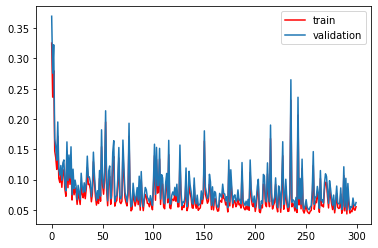

In [ ]:
net.load_state_dict(torch.load(path))
print(np.min(val_error_plt))
print(np.argmin(val_error_plt))
plt.plot(np.arange(N_EPOCHS), train_error_plt, color = "r")
plt.plot(np.arange(N_EPOCHS), val_error_plt)
plt.legend(["train", "validation"], loc ="upper right")

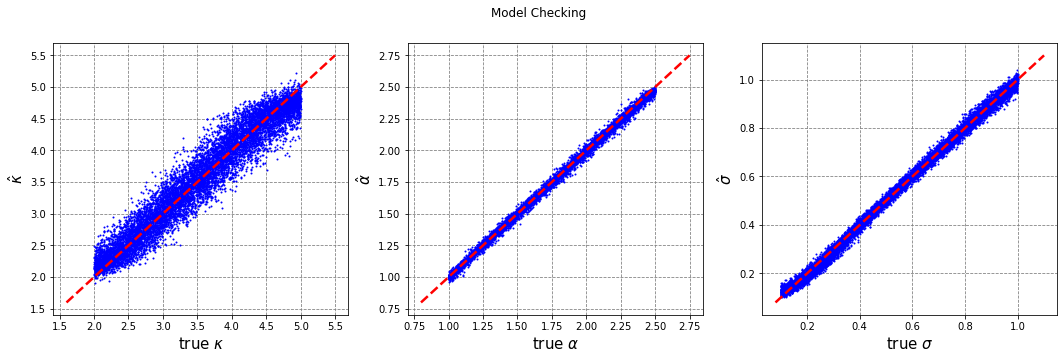

In [ ]:
with torch.no_grad():
  net.eval()
  tmp1 = net(X_test)[:,0]
  tmp2 = net(X_test)[:,1]
  tmp3 = net(X_test)[:,2]

  tmp1 = tmp1.detach().cpu().numpy().tolist()
  tmp2 = tmp2.detach().cpu().numpy().tolist()
  tmp3 = tmp3.detach().cpu().numpy().tolist()




# Plot for model checking
lim1 = [a_range[0] * 0.8, a_range[1] * 1.1]
lim2 = [b_range[0] * 0.8, b_range[1] * 1.1]
lim3 = [sigma_range[0] * 0.8, sigma_range[1] * 1.1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
fig.suptitle('Model Checking')

ax1.scatter(y_test[:,0], tmp1, marker='o', color='b', s =1)
ax1.set_xlabel('true $\kappa$', fontsize=15)
ax1.set_ylabel('$\hat{\kappa}$', fontsize=15)
ax1.plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')

ax2.scatter(y_test[:,1], tmp2, marker='o', color='b', s =1)
ax2.set_xlabel(r'true $\alpha$', fontsize=15 )
ax2.set_ylabel(r'$\hat{\alpha}$', fontsize=15)
ax2.plot(np.linspace(lim2[0], lim2[1], 1000), np.linspace(lim2[0], lim2[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='dashed')

ax3.scatter(y_test[:,2], tmp3, marker='o', color='b', s =1)
ax3.set_xlabel('true $\sigma$', fontsize=15)
ax3.set_ylabel('$\hat{\sigma}$', fontsize=15)
ax3.plot(np.linspace(lim3[0], lim3[1], 1000), np.linspace(lim3[0], lim3[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
ax3.set_axisbelow(True)
ax3.grid(color='gray', linestyle='dashed')

plt.show()

In [53]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving sim_data_CIR_2000_1.csv to sim_data_CIR_2000_1.csv
Saving sim_data_CIR_2000_2.csv to sim_data_CIR_2000_2.csv
Saving sim_data_CIR_2000_3.csv to sim_data_CIR_2000_3.csv


In [ ]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['sim_data_CIR_2000_1.csv']))
df2 = pd.read_csv(io.BytesIO(uploaded['sim_data_CIR_2000_2.csv']))
df3 = pd.read_csv(io.BytesIO(uploaded['sim_data_CIR_2000_3.csv']))

sim_data1= torch.tensor(df1.values.astype(np.float32))[:,1:(n+2)]
sim_data2= torch.tensor(df2.values.astype(np.float32))[:,1:(n+2)]
sim_data3= torch.tensor(df3.values.astype(np.float32))[:,1:(n+2)]

sim_data1_mom = moment_L(sim_data1)
sim_data2_mom = moment_L(sim_data2)
sim_data3_mom = moment_L(sim_data3)
sim = sim_data1.size()[0]


In [ ]:
param1 = torch.Tensor([3, 2, 0.5])
param2 = torch.Tensor([4,1.5,0.8])
param3 = torch.Tensor([2.5,2,0.2])

In [ ]:
net.eval()
print("NCoin-DP")
print(torch.mean(net(sim_data1_mom),0),torch.std(net(sim_data1_mom),0)) # (3, 2,0.5)
print(torch.mean(net(sim_data2_mom),0),torch.std(net(sim_data2_mom),0)) # (4, 1.5, 0.8)
print(torch.mean(net(sim_data3_mom),0),torch.std(net(sim_data3_mom),0)) # (2.5, 2, 0.2)

print("NCoin-DP RMSE")
print(torch.sqrt((torch.sum(torch.square(net(sim_data1_mom)[:,0] - param1[0])) +torch.sum(torch.square(net(sim_data1_mom)[:,1] - param1[1])) +torch.sum(torch.square(net(sim_data1_mom)[:,2] - param1[2]))) /sim ) )
print(torch.sqrt((torch.sum(torch.square(net(sim_data2_mom)[:,0] - param2[0])) +torch.sum(torch.square(net(sim_data2_mom)[:,1] - param2[1])) +torch.sum(torch.square(net(sim_data2_mom)[:,2] - param2[2])))/sim) )
print(torch.sqrt((torch.sum(torch.square(net(sim_data3_mom)[:,0] - param3[0])) +torch.sum(torch.square(net(sim_data3_mom)[:,1] - param3[1])) +torch.sum(torch.square(net(sim_data3_mom)[:,2] - param3[2])))/sim))

NCoin-DP
tensor([2.9939, 2.0032, 0.4904], grad_fn=<MeanBackward1>) tensor([0.2034, 0.0172, 0.0103], grad_fn=<StdBackward0>)
tensor([3.9913, 1.4994, 0.7929], grad_fn=<MeanBackward1>) tensor([0.2646, 0.0168, 0.0145], grad_fn=<StdBackward0>)
tensor([2.4925, 1.9984, 0.1787], grad_fn=<MeanBackward1>) tensor([0.1050, 0.0095, 0.0060], grad_fn=<StdBackward0>)
NCoin-DP RMSE
tensor(0.2046, grad_fn=<SqrtBackward0>)
tensor(0.2655, grad_fn=<SqrtBackward0>)
tensor(0.1079, grad_fn=<SqrtBackward0>)
